In [1]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES

In [2]:
def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]

def prepare_problem(PARAMETER_RANGES, dependent_param="Pc_des"):
    independent_params = {
        k: v for k, v in PARAMETER_RANGES.items()
        if k != dependent_param
    }
    # Add dummy variable to later compute dependent_param
    z_key = f"z_{dependent_param}"
    independent_params[z_key] = (0, 1)

    bounds = [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
    bounds = make_bounds_exclusive(bounds)

    problem = {
        "num_vars": len(independent_params),
        "names": list(independent_params.keys()),
        "bounds": bounds,
        "groups": list(independent_params.keys())  # optional but useful for group-based SA
    }
    return problem

problem = prepare_problem(PARAMETER_RANGES)

In [3]:
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
import random

def generate_samples(problem, N=2, num_levels=4, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    samples = morris.sample(problem, N=N, num_levels=num_levels)

    # Add a new column for the trajectory number
    trajectory_numbers = np.tile(np.arange(1, N + 1), (problem["num_vars"], 1)).flatten()

    return pd.DataFrame(samples, columns=problem["names"]), trajectory_numbers

def compute_dependent_param(df_samples, param_name="Pc_des", Pext=101325):
    z_key = f"z_{param_name}"
    Pa_des = df_samples["Pa_des"]
    z = df_samples[z_key]

    low = np.maximum(Pext, Pa_des - 0.5e5)
    high = np.maximum(Pext, Pa_des - 0.1e5)

    df_samples[param_name] = low + z * (high - low)
    df_samples = df_samples.drop(columns=z_key)
    return df_samples, low, high

df_samples, trajectory_numbers = generate_samples(problem, N=10, num_levels=4)
df_samples, low, high = compute_dependent_param(df_samples)
print(df_samples.shape)

df_samples['e'] = np.round(df_samples['e'])


(200, 19)


In [33]:
def is_sample_in_bounds(sample, bounds_dict):
    """
    Check if a sample is within the specified parameter bounds.

    Args:
        sample (dict): A dictionary of parameter values.
        bounds_dict (dict): A dictionary with parameter names as keys and tuples or lists as bounds.

    Returns:
        bool: True if all parameters are within bounds, False otherwise.
        dict: A dictionary of out-of-bound parameters with their values and bounds.
    """
    out_of_bounds = {}

    for key, bounds in bounds_dict.items():
        if key not in sample:
            continue  # skip if not part of the sample

        value = sample[key]

        if bounds is None:
            continue  # no bounds specified

        if isinstance(bounds, tuple):
            lower, upper = bounds
            if not (lower <= value <= upper):
                out_of_bounds[key] = {"value": value, "bounds": bounds}

        elif isinstance(bounds, list):
            if value not in bounds:
                out_of_bounds[key] = {"value": value, "allowed": bounds}

    return len(out_of_bounds) == 0, out_of_bounds

for sample in df_samples.to_dict(orient='records'):
    res = is_sample_in_bounds(sample, bounds_dict=PARAMETER_RANGES)
    if res[0] == False:
        print(res[1])

In [34]:
results = get_polarisation_curve_samples(df_samples.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path='../data/raw/morris_sample_results_N10_lev4.pkl')


✅ Saved 10 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 20 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 30 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 40 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 50 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 60 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 70 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 80 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 90 samples to ../data/raw/morris_sample_results_N10_lev4.pkl
✅ Saved 100 samples to ../data/raw/morris_sample_results_N10_lev4.pkl


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\external\AlphaPEM\model\dif_eq.py:396: RuntimeWarning: overflow encountered in exp
  np.exp(f_drop * alpha_c * F / (R * Tfc) * eta_c))
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\scipy\integrate\_ivp\common.py:347: RuntimeWarning: invalid value encountered in subtract
  diff = f_new - f[:, None]


❌ Sample 107 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 2.99999999, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 2.9999999966666664, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.29999999, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
   Error: array must not contain infs or NaNs
❌ Sample 108 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 2.99999999, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 1.00000001, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.29999999, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_sw

In [ ]:
# The following samples cause problems
#❌ Sample 107 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 2.99999999, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 2.9999999966666664, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.29999999, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
#   Error: array must not contain infs or NaNs
#❌ Sample 108 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 2.99999999, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 1.00000001, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.29999999, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
#   Error: array must not contain infs or NaNs
#❌ Sample 109 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 2.99999999, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 1.00000001, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.20000000333333334, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
#   Error: array must not contain infs or NaNs
#❌ Sample 110 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 1.7333333366666668, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 1.00000001, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.20000000333333334, 'e': 4.0, 'Re': 2.0033333333333334e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
#   Error: array must not contain infs or NaNs
#❌ Sample 111 not valid: {'Tfc': 352.99999999666665, 'Pa_des': 110000.00000001, 'Sa': 1.7333333366666668, 'Sc': 1.10000001, 'Phi_a_des': 0.6999999966666666, 'Phi_c_des': 0.99999999, 'epsilon_gdl': 0.6333333366666667, 'tau': 1.00000001, 'epsilon_mc': 0.15000001, 'epsilon_c': 0.20000000333333334, 'e': 4.0, 'Re': 4.9900000000000005e-06, 'i0_c_ref': 166.6673333366667, 'kappa_co': 26.669999996666665, 'kappa_c': 99.99999999, 'a_slim': 0.99999999, 'b_slim': 1e-08, 'a_switch': 0.33333333666666665, 'Pc_des': 101325.0}
#   Error: array must not contain infs or NaNs

results = pd.read_pickle('../data/raw/morris_sample_results_N10_lev4_corrected.pkl')

[100, 101, 102, 103, 104, 105, 106, 112, 113, 114, 115, 116, 117, 118, 119]


In [4]:
def replace_z_with_actual_param(problem, low, high, param_name="Pc_des"):
    z_key = f"z_{param_name}"
    idx = problem["names"].index(z_key)
    problem["names"][idx] = param_name
    problem["bounds"][idx] = (low.min(), high.max())
    problem["groups"][idx] = param_name
    return problem

problem = replace_z_with_actual_param(problem, low, high)

In [ ]:
def run_morris_analysis(df_samples, problem, results, output_key='Ucell', num_levels=4):
    Y_all = np.stack(results[output_key].values)
    n_outputs = Y_all.shape[1]

    morris_all = []
    for i in range(n_outputs):
        analysis = morris_analyze.analyze(
            problem=problem,
            X=df_samples.to_numpy(),
            Y=Y_all[:, i],
            conf_level=0.95,
            num_levels=num_levels,
            print_to_console=False
        )
        morris_all.append({
            'mu_star': analysis['mu_star'],
            'sigma': analysis['sigma'],
            'param': problem['names'],
            'output_index': i
        })
    return morris_all

morris_all = run_morris_analysis(df_samples, problem, results)


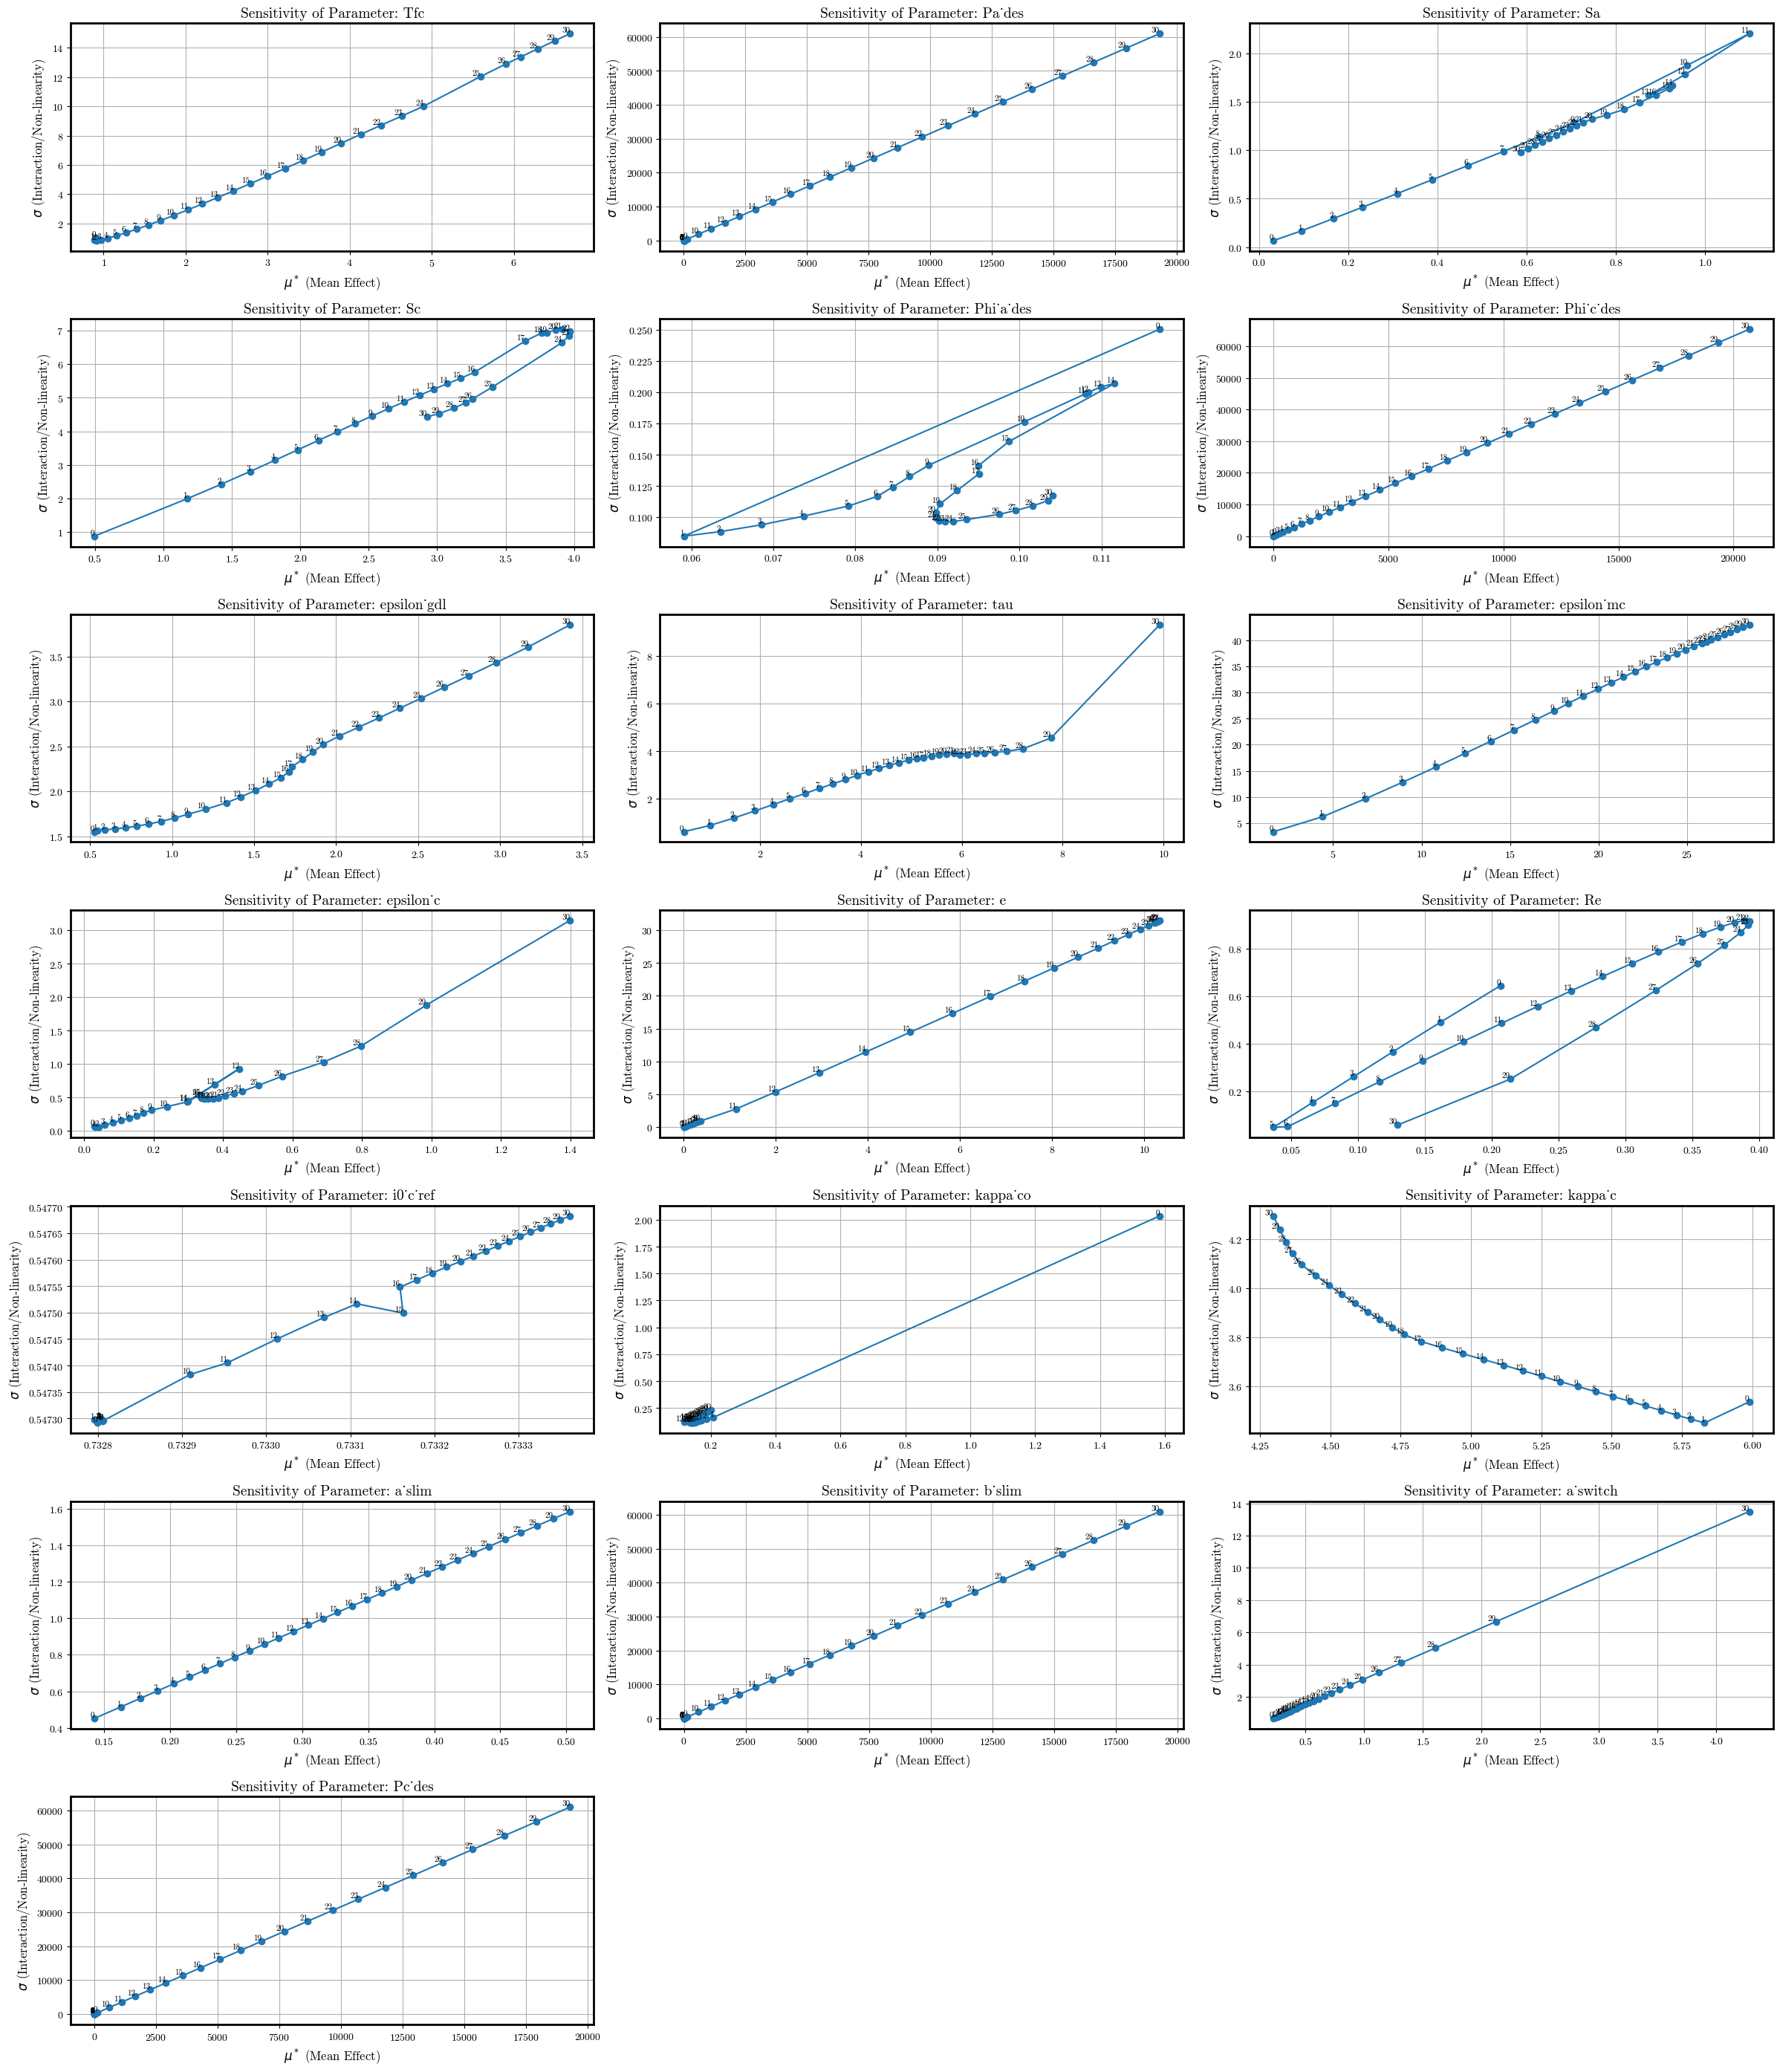

In [6]:
import matplotlib.pyplot as plt
import math

def plot_morris_sensitivity_entire_function(morris_all, problem, n_cols=3):
    """
    Plots the sensitivity of parameters based on morris_all results in subplots.
    
    Parameters:
        morris_all (list of dict): List containing the sensitivity analysis results.
        problem (dict): Dictionary containing problem information, including parameter names.
        n_cols (int): Number of columns in the subplot grid (default is 3).
    """
    params = problem['names']
    n_params = len(params)
    n_outputs = len(morris_all)

    # Calculate the number of rows needed based on number of columns
    n_rows = math.ceil(n_params / n_cols)

    # Create subplots with the calculated number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Loop through each parameter and create a plot in the corresponding subplot
    for param_idx, ax in enumerate(axes):
        if param_idx >= n_params:
            ax.axis('off')  # Hide empty subplots if there are fewer parameters than subplots
            continue

        mu_star_vals = []
        sigma_vals = []
        output_indices = []

        for output in morris_all:
            mu_star_vals.append(output['mu_star'][param_idx])
            sigma_vals.append(output['sigma'][param_idx])
            output_indices.append(output['output_index'])

        ax.plot(mu_star_vals, sigma_vals, marker='o', linestyle='-')
        
        for i, (mu, sigma) in enumerate(zip(mu_star_vals, sigma_vals)):
            ax.text(mu, sigma, str(output_indices[i]), fontsize=8, ha='right', va='bottom')

        ax.set_xlabel(r'$\mu^*$ (Mean Effect)', fontsize=12)
        ax.set_ylabel(r'$\sigma$ (Interaction/Non-linearity)', fontsize=12)
        ax.set_title(f'Sensitivity of Parameter: {params[param_idx]}', fontsize=14)
        ax.grid(True)

    # Adjust layout and add extra vertical space
    plt.subplots_adjust(hspace=0.4)  # Adjust this value to control the vertical space
    plt.tight_layout()
    plt.show()

plot_morris_sensitivity_entire_function(morris_all, problem)

C:\Users\dejvi\AppData\Local\Temp\ipykernel_20884\3706683639.py:29: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\dejvi\AppData\Local\Temp\ipykernel_20884\3706683639.py:29: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  plt.tight_layout()
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


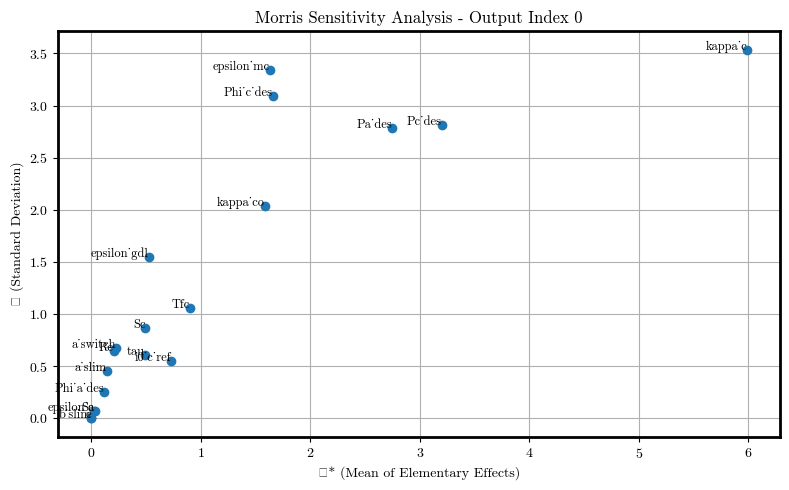

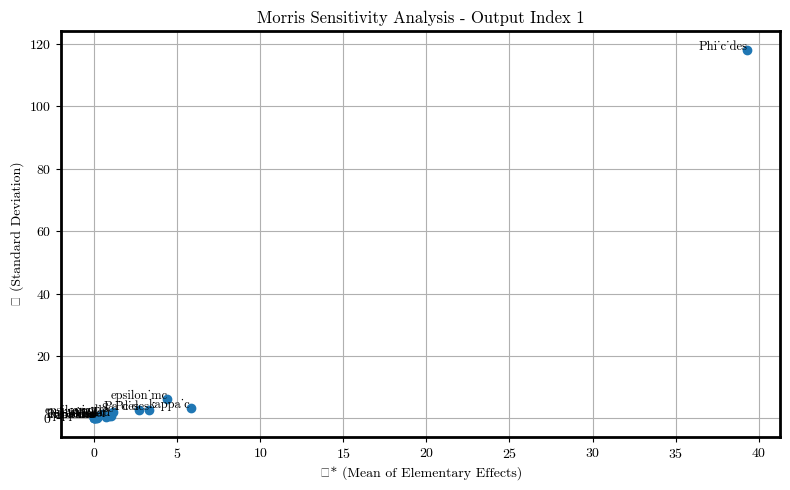

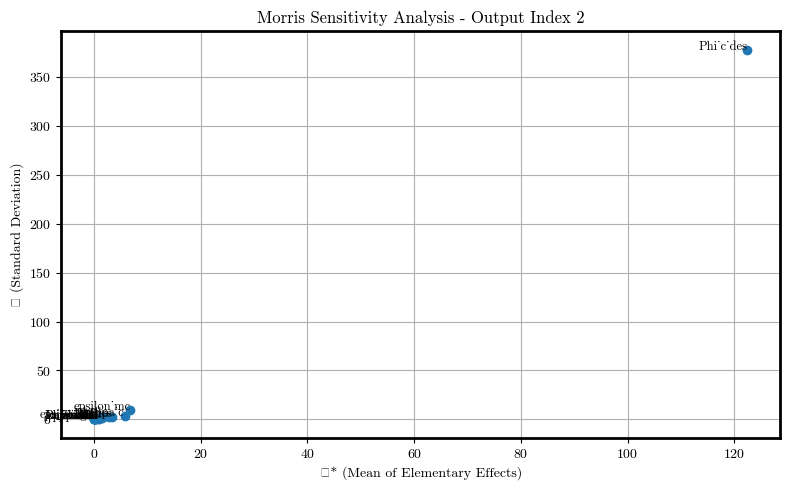

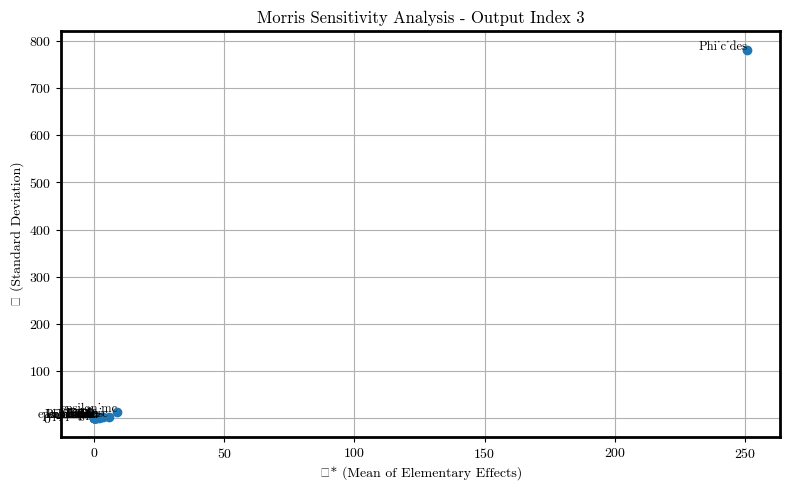

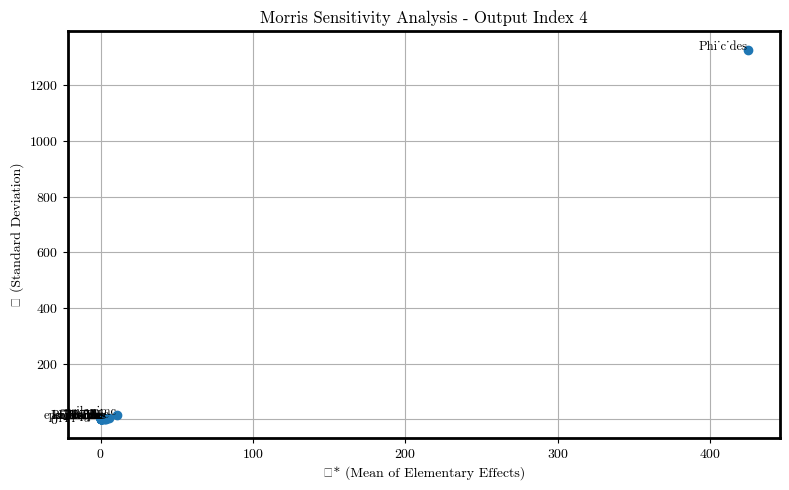

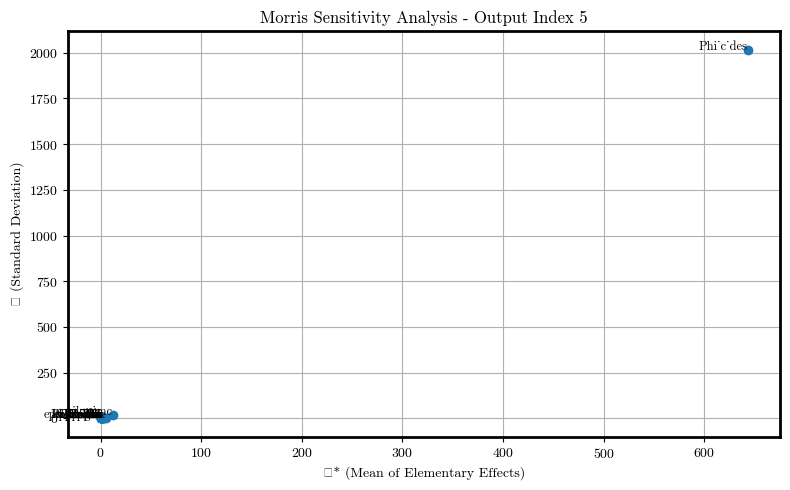

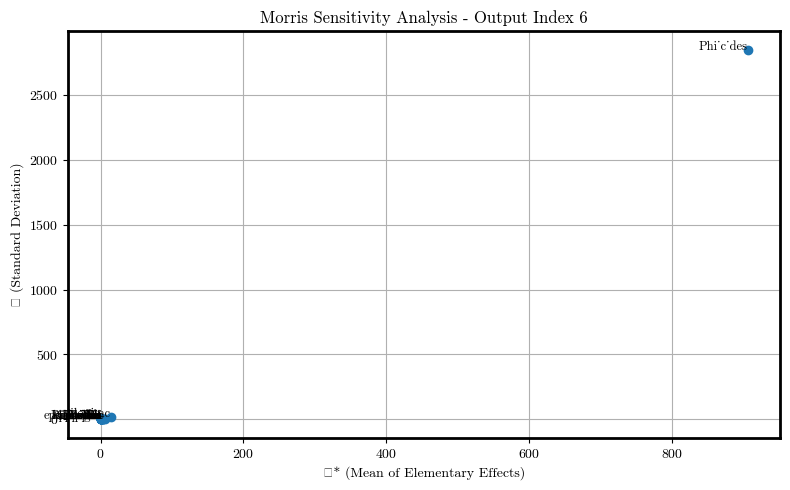

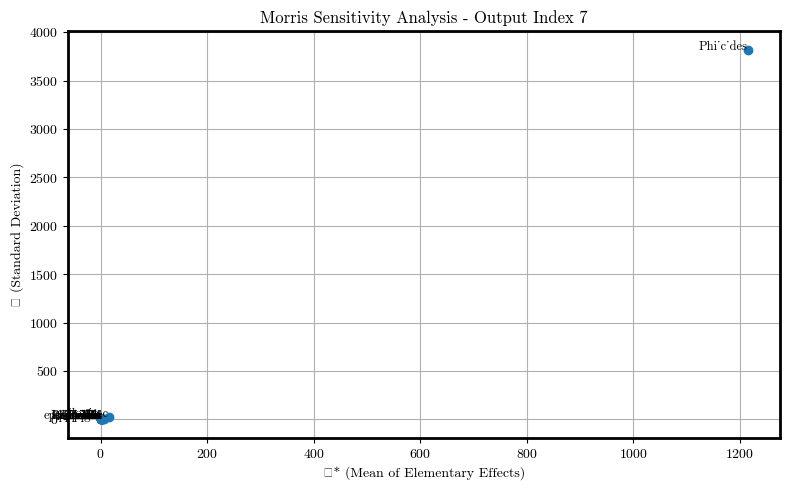

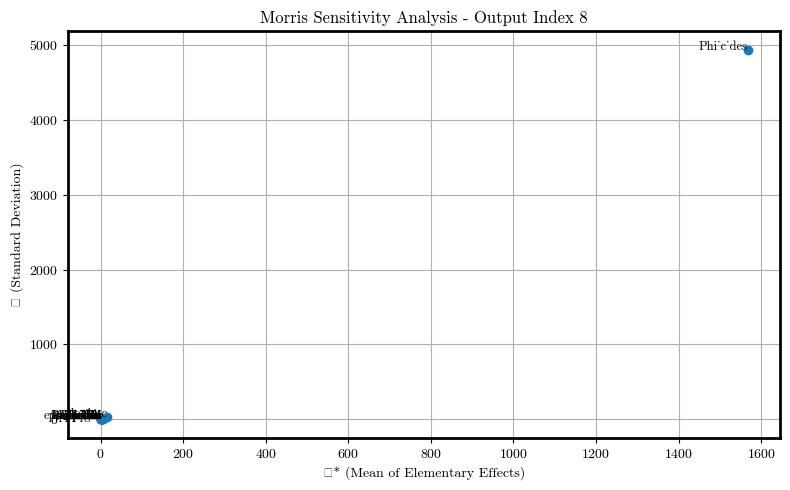

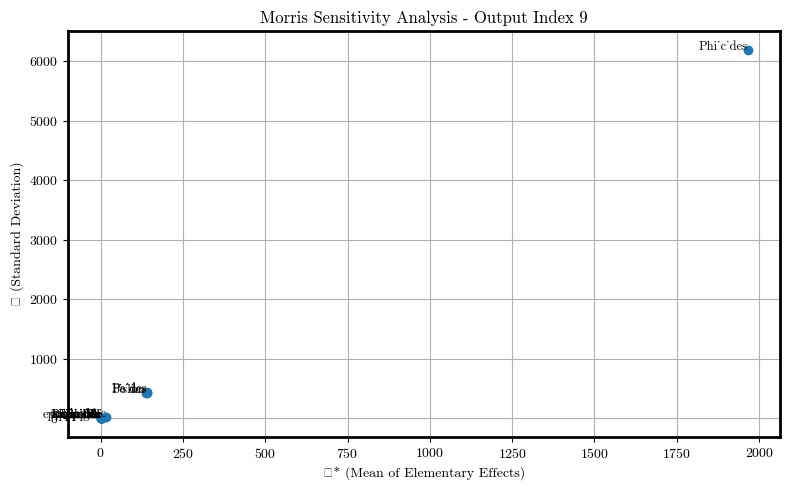

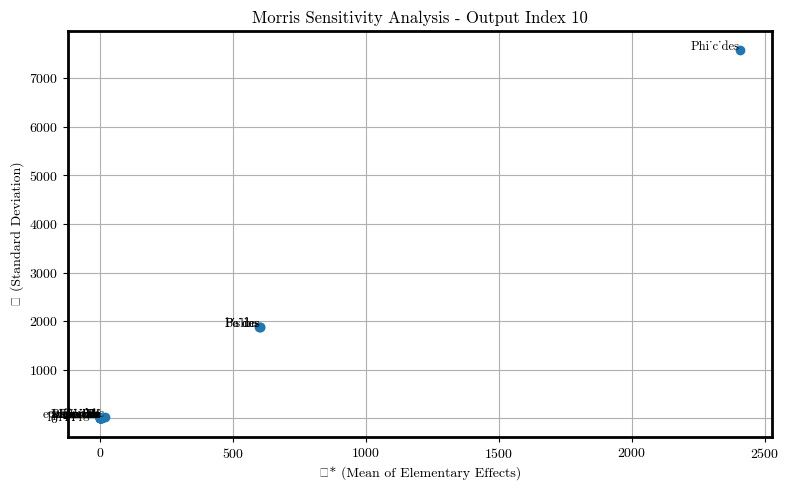

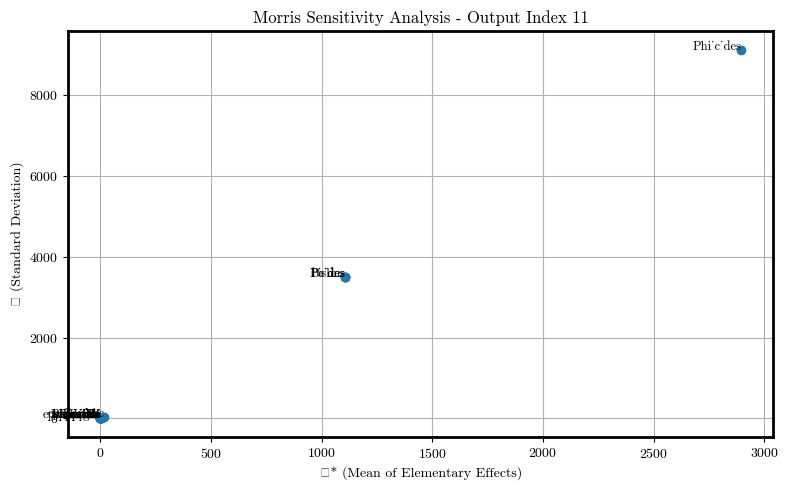

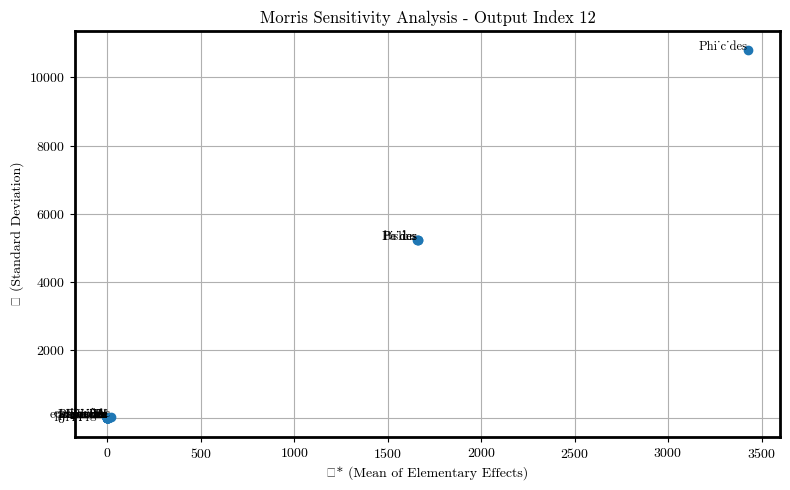

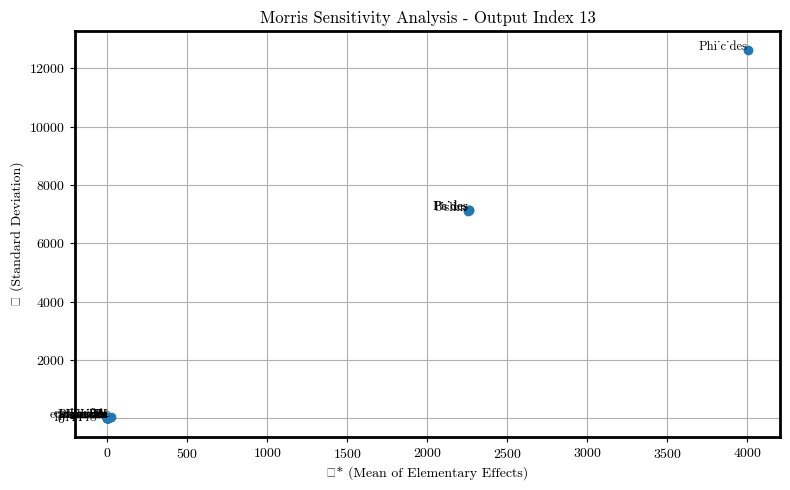

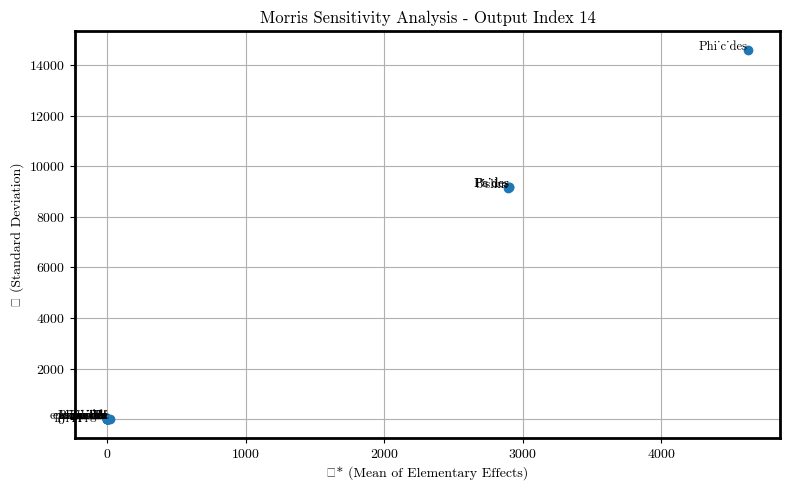

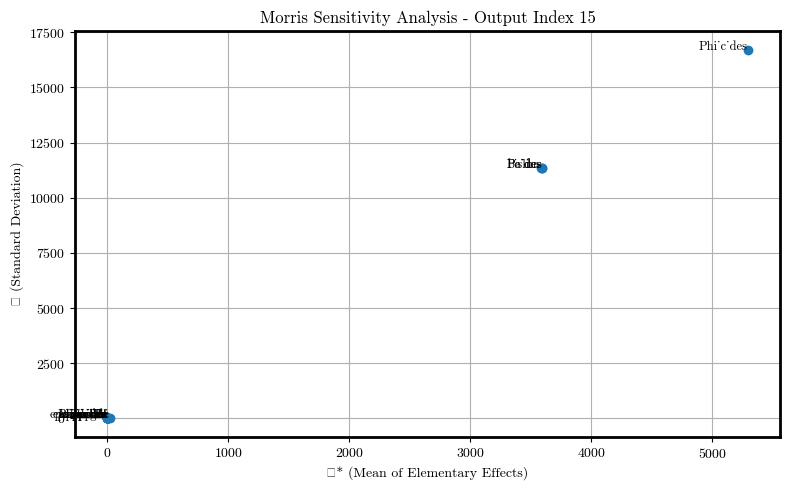

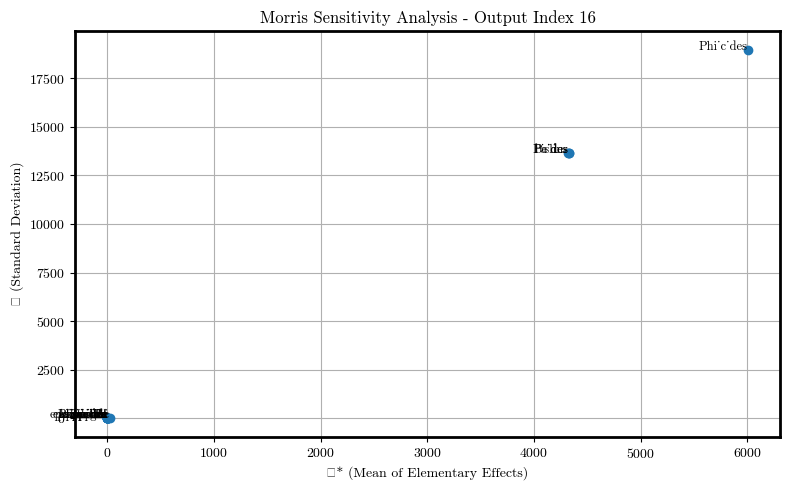

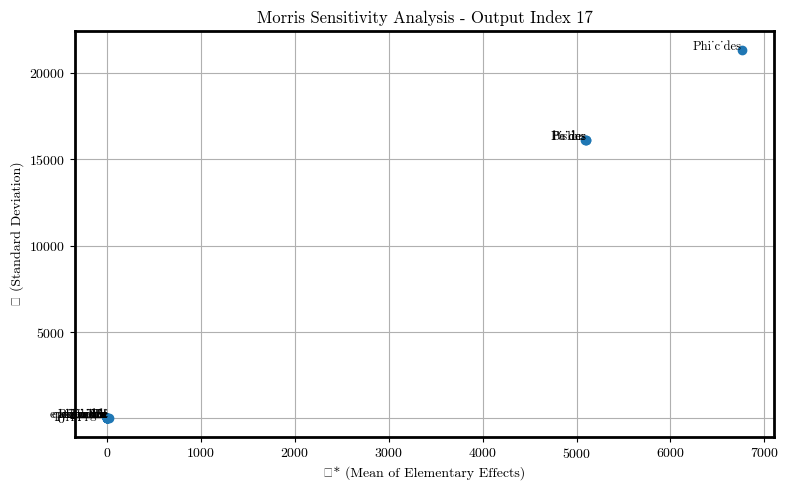

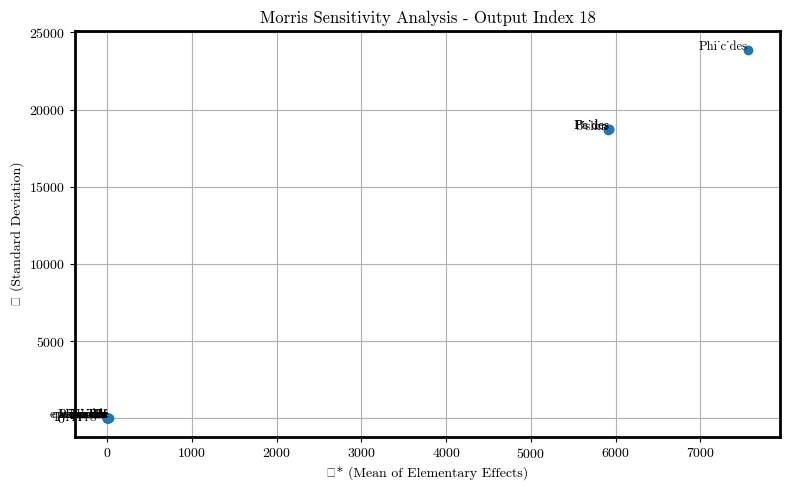

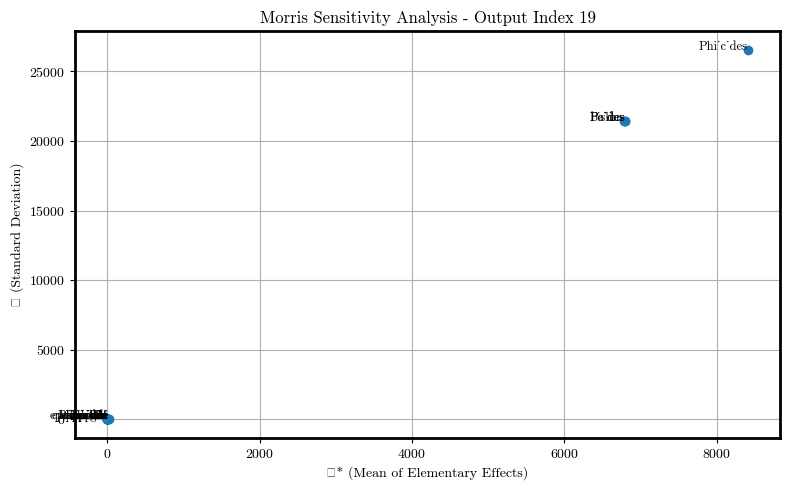

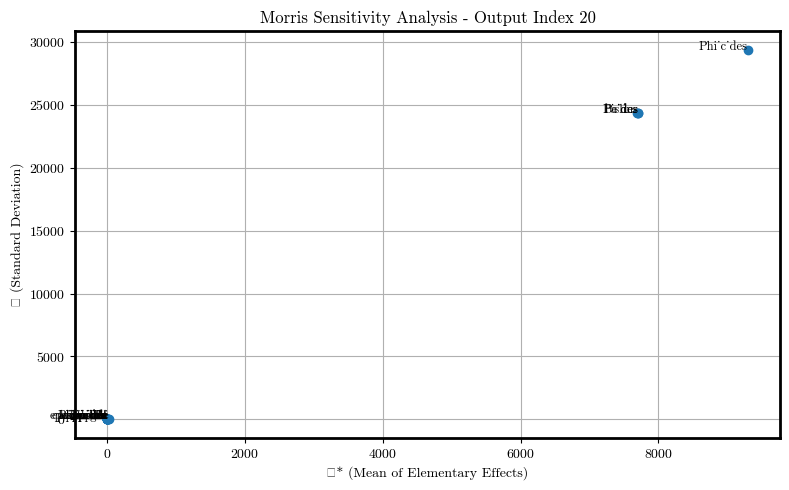

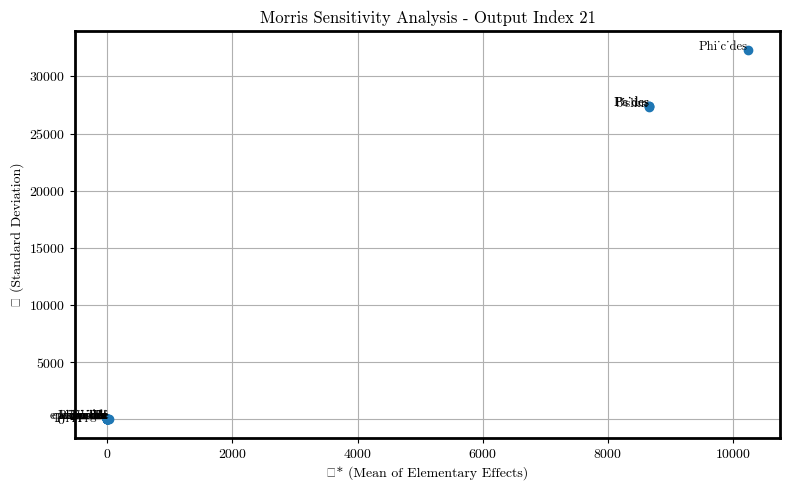

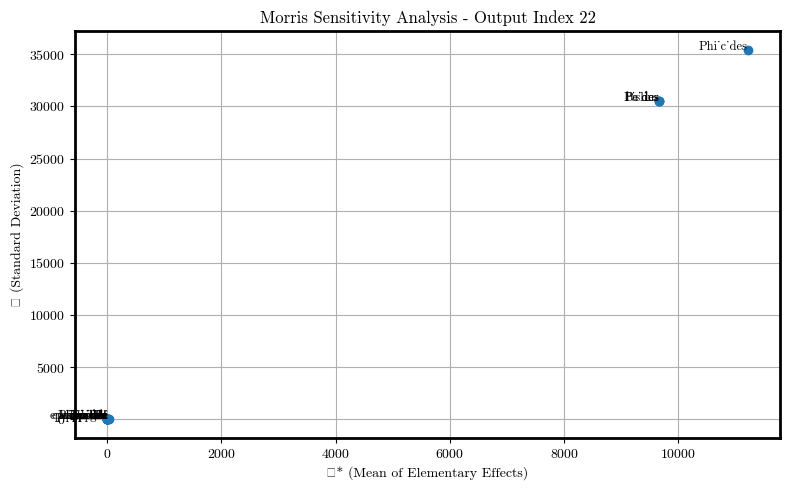

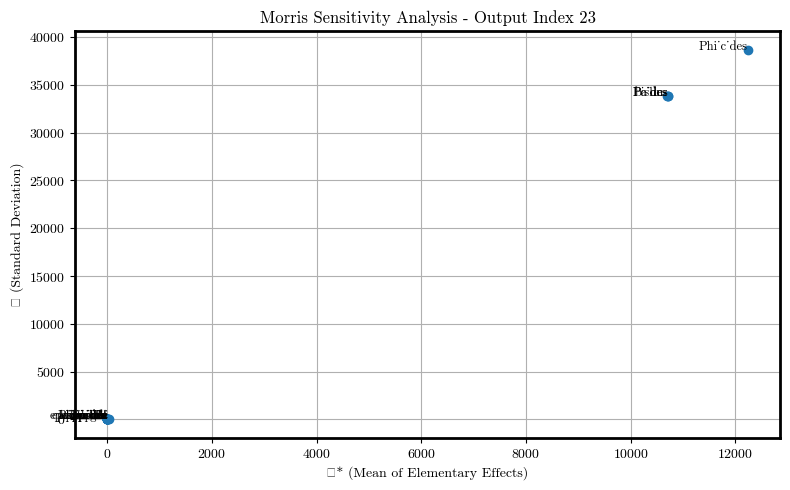

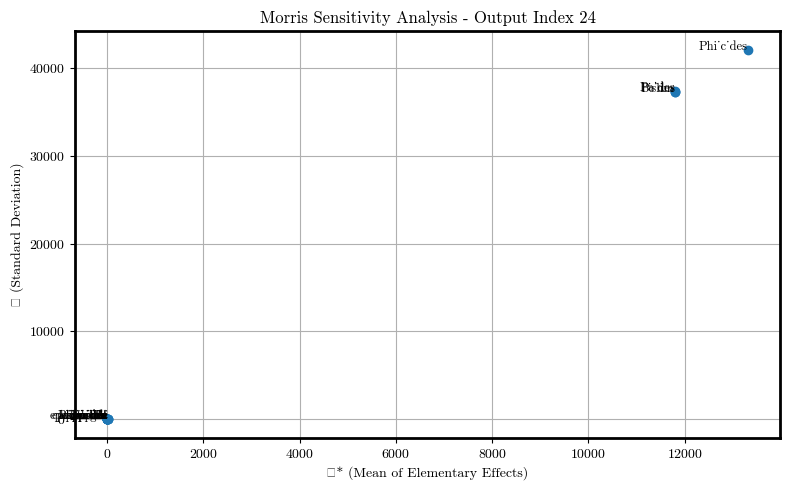

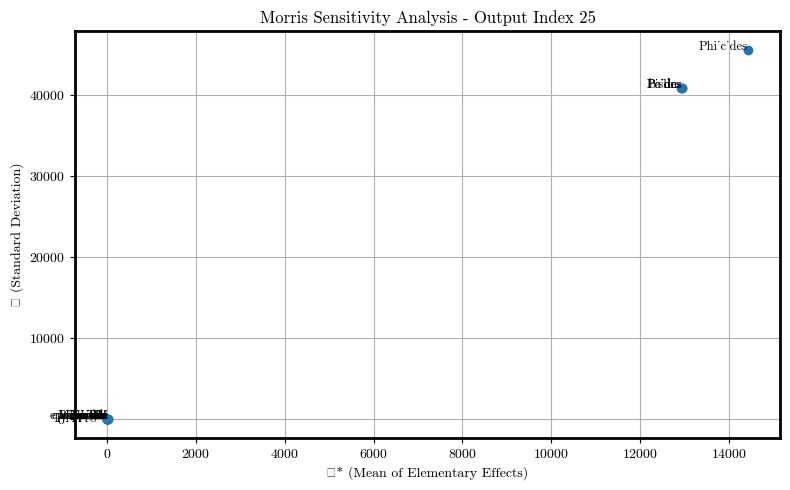

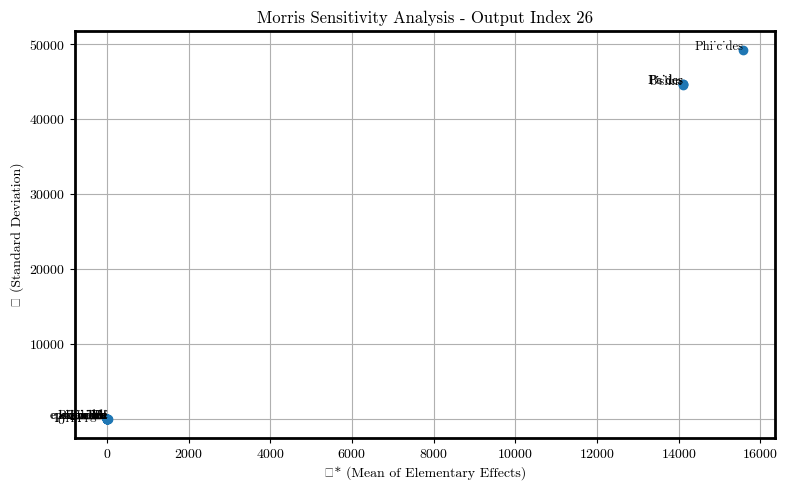

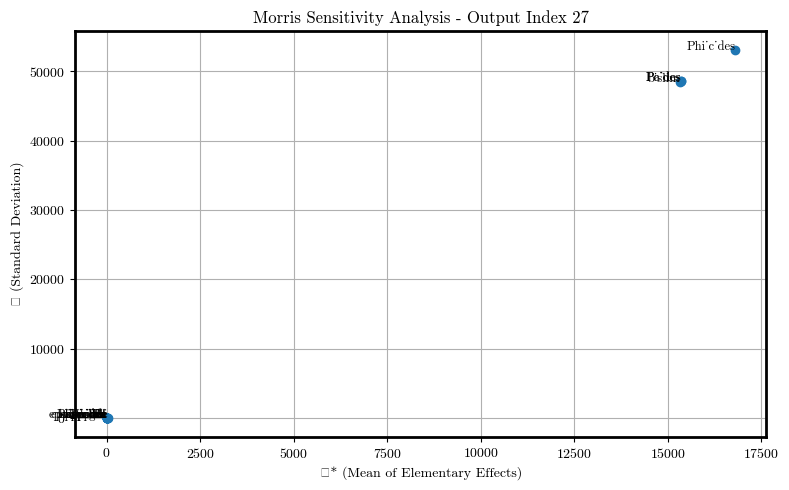

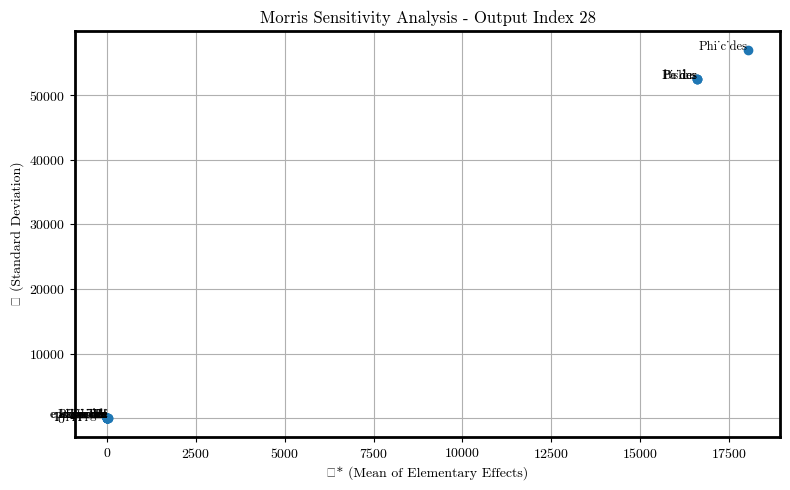

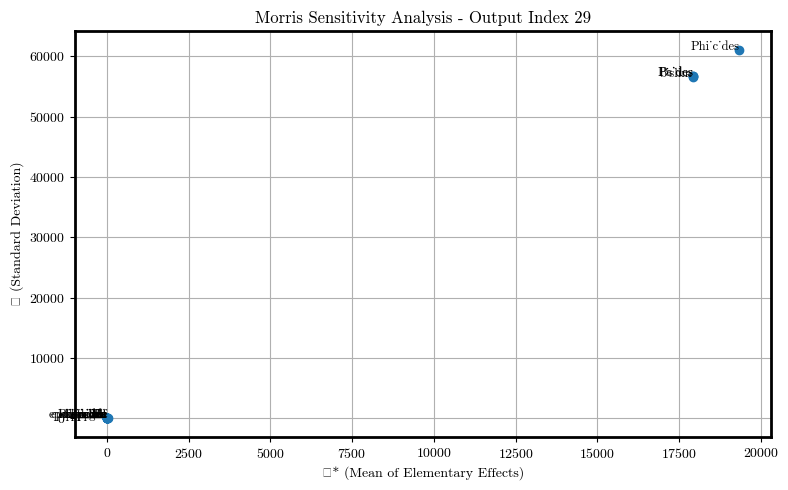

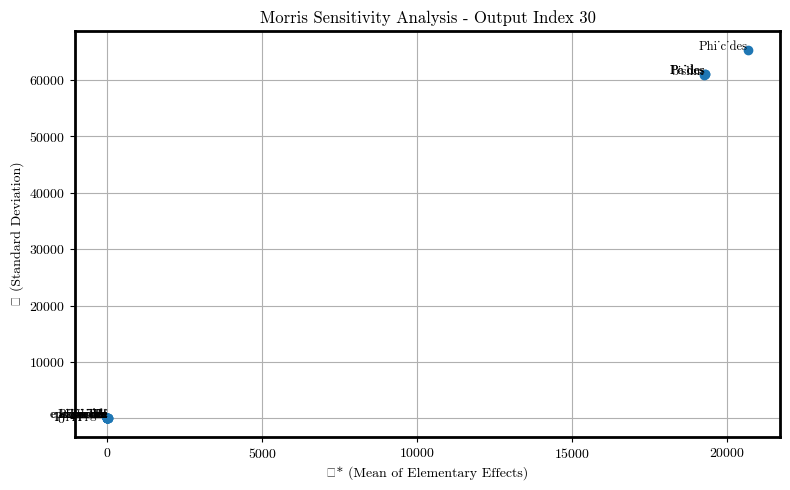

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_sensitivity_per_index(morris_all, figsize=(8, 5)):
    """
    Plots Morris sensitivity analysis results.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma', 'param', and 'output_index'
    - figsize: tuple, size of each plot
    """
    n_outputs = len(morris_all)

    for i in range(n_outputs):
        result = morris_all[i]
        mu_star = result['mu_star']
        sigma = result['sigma']
        param_names = result['param']

        plt.figure(figsize=figsize)
        plt.errorbar(mu_star, sigma, fmt='o', ecolor='gray', capsize=5)
        for j, param in enumerate(param_names):
            plt.text(mu_star[j], sigma[j], param, fontsize=9, ha='right')

        plt.title(f"Morris Sensitivity Analysis - Output Index {i}")
        plt.xlabel("μ* (Mean of Elementary Effects)")
        plt.ylabel("σ (Standard Deviation)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_morris_sensitivity_per_index(morris_all)

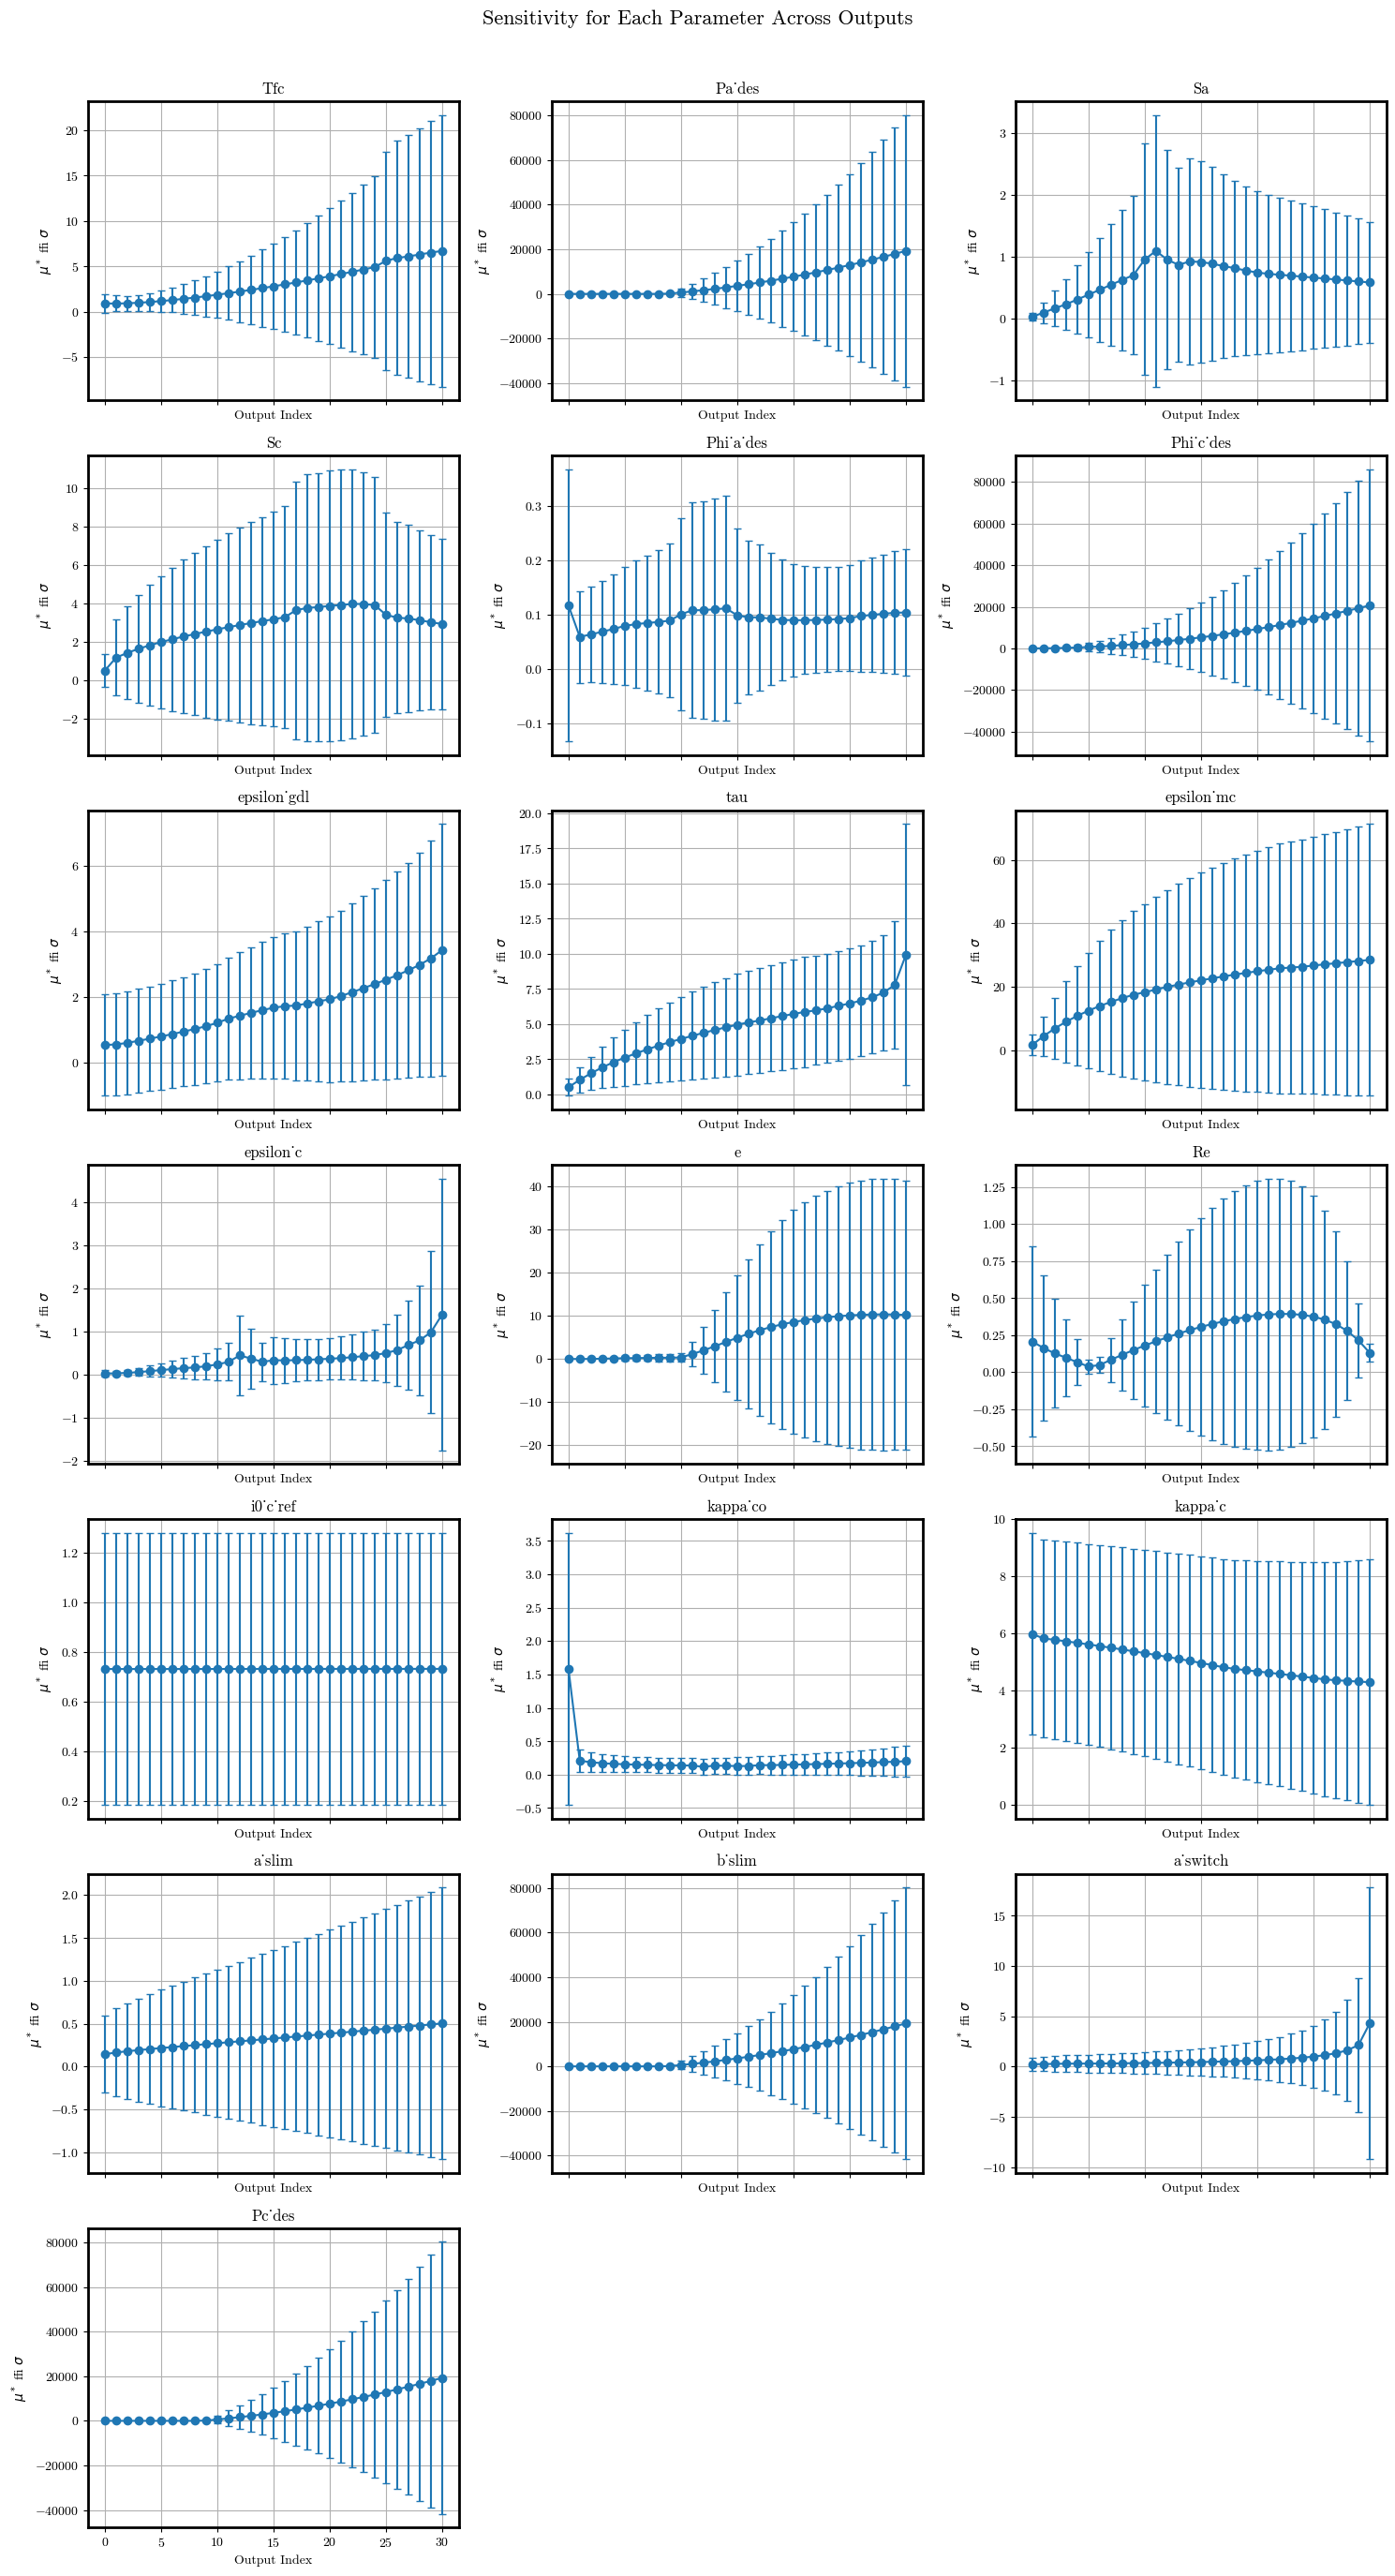

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_grid(morris_all, params, n_cols=3):
    """
    Plot a grid of subplots showing sensitivity (mu_star ± sigma) for each parameter across outputs.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma' (output of Morris analysis for each output index)
    - params: list of parameter names
    - n_cols: number of columns in subplot grid (default is 3)
    """
    n_params = len(params)
    n_outputs = len(morris_all)
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True)

    for i in range(n_params):
        ax = axes.flat[i]
        mu_star_vals = [out['mu_star'][i] for out in morris_all]
        sigma_vals = [out['sigma'][i] for out in morris_all]
        ax.errorbar(range(n_outputs), mu_star_vals, yerr=sigma_vals, fmt='-o', capsize=3)
        ax.set_title(params[i])
        ax.set_xlabel("Output Index")
        ax.set_ylabel(r"$\mu^*$ ± $\sigma$")
        ax.grid(True)

    # Remove unused axes
    for j in range(n_params, n_rows * n_cols):
        fig.delaxes(axes.flat[j])

    fig.suptitle("Sensitivity for Each Parameter Across Outputs", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_morris_grid(morris_all, params=problem['names'])


In [9]:
import numpy as np
import pandas as pd

def summarize_morris_results(morris_all, problem):
    """
    Summarizes Morris sensitivity analysis across multiple outputs.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star' (list of float) and 'param' (list of str)
    - problem: dict containing 'names' (list of parameter names)

    Returns:
    - df_summary: DataFrame with mean and std of mu_star across outputs, sorted by importance
    """
    params = problem['names']
    mu_star_matrix = np.array([output['mu_star'] for output in morris_all])

    mu_star_mean = mu_star_matrix.mean(axis=0)
    mu_star_std = mu_star_matrix.std(axis=0)

    df_summary = pd.DataFrame({
        'Parameter': params,
        'Mu*_mean': mu_star_mean,
        'Mu*_std': mu_star_std
    })

    df_summary = df_summary.sort_values(by='Mu*_mean', ascending=False).reset_index(drop=True)
    return df_summary

summarize_morris_results(morris_all, problem)

,Parameter,Mu*_mean,Mu*_std
0,Phi_c_des,7087.789746,6370.444963
1,Pc_des,5781.686054,6155.542865
2,Pa_des,5781.451944,6155.547961
3,b_slim,5773.249960,6151.283486
4,epsilon_mc,19.937094,7.345961
5,kappa_c,5.022983,0.516752
6,e,4.922023,4.263667
7,tau,4.702489,2.077450
8,Tfc,3.159308,1.873651
9,Sc,2.851315,0.881984
